# RA2CE feature: Equity analysis

This notebook is a rather technical notebook. The recommended user is a user with background knowledge of network criticality. 

In this notebook, we will perform criticality analysis with three different distributive principles: utilitarian, egalitarian and prioritarian principles. For more background knowledge on these principles and the application on transport network criticality analysis, please read: https://www.sciencedirect.com/science/article/pii/S0965856420308077 

The purpose of the equity analysis performd in this notebook is providing insight into how different distributive principles can result in different prioritizations of the network. While we usually prioritize network interventions based on the number of people that use the road, equity principles allow us to also take into account the function of the network for for example underpriviliged communities. 
Depending on the equity principle applied, your network prioritization might change, which can change decision-aking.

The RA2CE analysis is set up generically. The user can determine the equity weights themselves. This can for example be GINI-coefficients or social vulnerability scores. The user-defined equity weights will feed into the prioritarian principle.

The three applied principles are explained below:

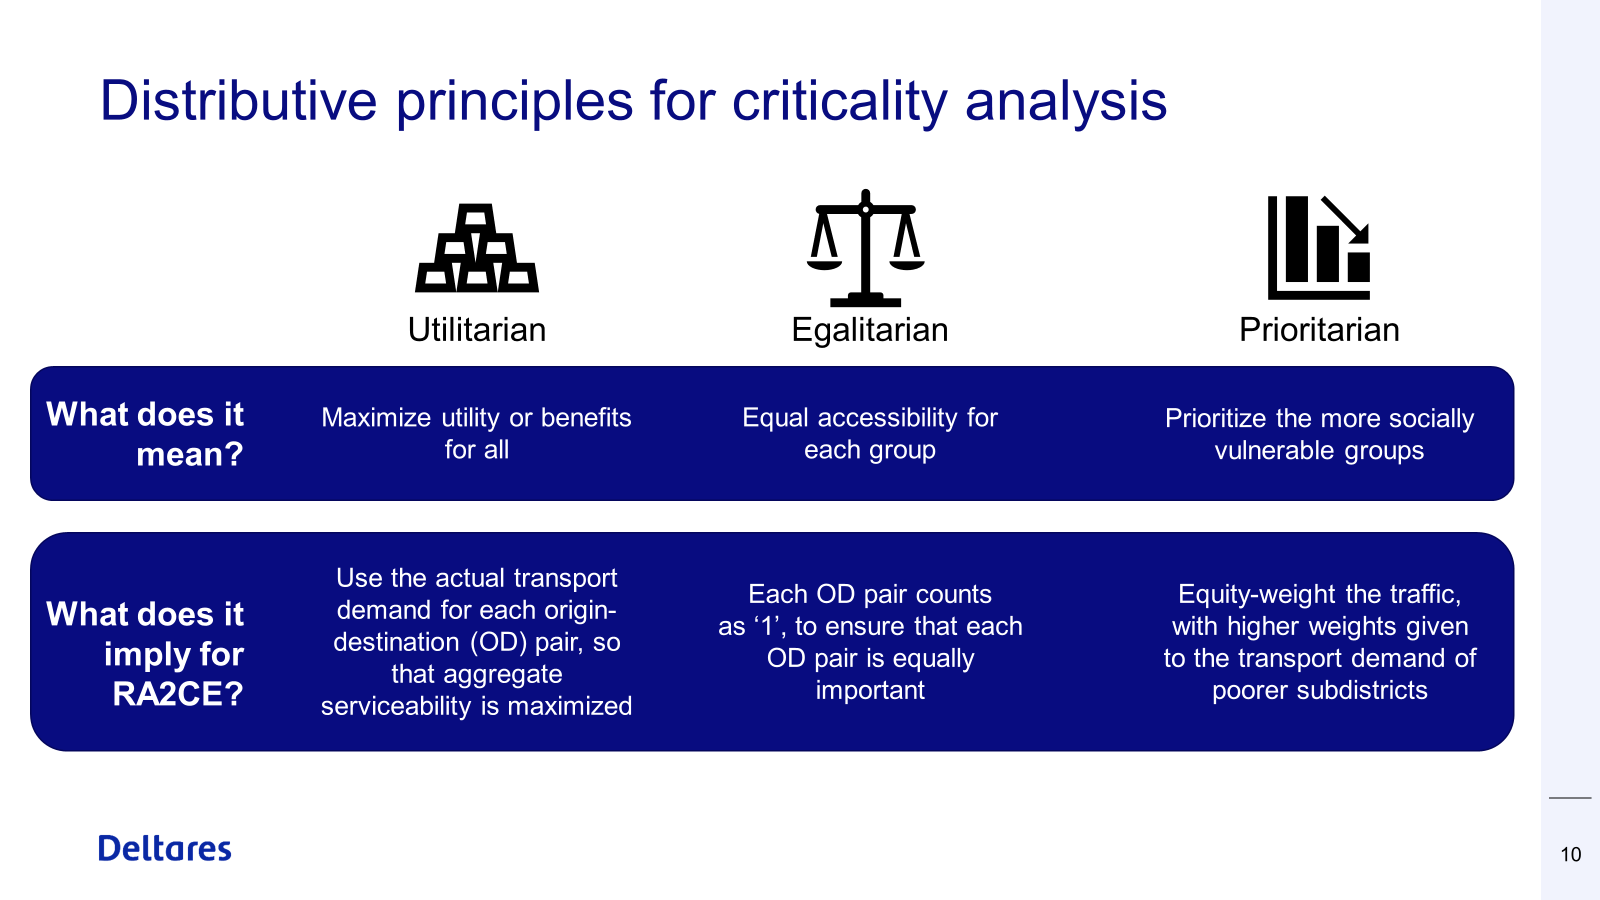

# For new users

If you have not checked out the previous RA2CE examples and you want to run your own RA2CE analysis, we advise you to first familiarize yourself with those notebooks. In this current notebook we will not provide extensive explanations as to how to run RA2CE and create the correct setups. We will assume the user has this knowledge already. 

### Do your imports first

In [137]:
import ast
import random
import sys
import webbrowser
import geopandas as gpd
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib.pyplot import get_cmap
from matplotlib.colors import to_hex
from pathlib import Path
import rasterio
import folium

## Setting up RA2CE for the equity analysis

For the equity analysis, the user needs to create origin and destinations pairs as we have done before.

Additionally, there is a possibility to assign equity weights which can be used in the criticality analysis. For this analysis, we use a region weights file (region_weight.csv) which holds weights for specific areas or regions. You then also need a shapefile delineating the regions in question. We will inspect both files in this example:

In [138]:
root_dir = Path("data", "equity_analysis")
assert root_dir.exists()

In [139]:
# load the region weights file:
path_network = root_dir / "static" / "network"
path_region_weights = path_network / "region_weight.csv"
path_regions = path_network / "region.shp"

region_weigths = pd.read_csv(path_region_weights, sep=';')
regions = gpd.read_file(path_regions, driver = "SHP")


In [ ]:
region_weigths

In [ ]:
regions.explore(column='DESA')

### Set up your network and analysis ini

Before you start running, you need to make sure that your .ini files contain the right parameters. Check out the analysis and network.ini files in the data folder to check the additional parameters that need to be set to run this example! Below we paste a snippet of these files as example

**Network Ini update section origins_destinations**<br>
[origins_destinations]<br>
origins = origins_points.shp # Must be in the static/network folder, belongs to this analysis <br>
destinations = osm_health_point.shp # gis_osm_pois_pontianak.shp # Must be in the static/network folder, belongs to this analysis<br>
origins_names = A<br>
destinations_names = B<br>
id_name_origin_destination = OBJECTID #default if origins is a tif file = OBJECTID<br>
origin_count = values #necessary if traffic on each edge would be recorded in optimal_route_origin_destination<br>
origin_out_fraction = 1<br>
category = category<br>
region = region.shp #necessary for distributional / equity analysis<br>
region_var = DESA #necessary for distributional / equity analysis<br>

**analysis_ini update optimal_route_origin_destination analysis**<br>
[analysis1]<br>
name = optimal route origin destination<br>
analysis = optimal_route_origin_destination<br>
weighing = length<br>
save_traffic = True #True if you want to record the traffic in each edge<br>
equity_weight = region_weight.csv #equity-weighted factors for each region, should be stored in static/network. Note that 'region' and 'region_var' should present in network.ini<br>
save_gpkg = True<br>
save_csv = True<br>



## Perform your RA2CE analysis

Now we can start our RA2CE analysis. Let's initialize RA2CE first

In [ ]:
from ra2ce.ra2ce_handler import Ra2ceHandler #import the ra2cehandler to run ra2ce analyses

_network_ini_name = "network.ini" #set the name for the network.ini
_analysis_ini_name = "analyses.ini" #set the name for the analysis.ini

In [ ]:
network_ini = root_dir / _network_ini_name
assert network_ini.is_file()

analysis_ini = root_dir / _analysis_ini_name
assert analysis_ini.is_file()

Let's run RA2CE

In [ ]:
handler = Ra2ceHandler(network=network_ini, analysis=analysis_ini)
handler.configure()
handler.run_analysis()

## Inspect data

Load the origins and destinations data and the road network of our analysis

In [ ]:
path_network = root_dir / "static" / "network"
path_origins = path_network / "origins_points.shp"
path_destinations = path_network / "osm_health_point.shp"
origins = gpd.read_file(path_origins, driver = "SHP")
destinations = gpd.read_file(path_destinations, driver = "SHP")

path_output_graph = root_dir / "static" / "output_graph"
path_network = path_output_graph / "base_graph_edges.gpkg"
network = gpd.read_file(path_network, driver='GPKG')


Inspect origins (blue) and health destinations (red)

In [ ]:
m = origins.explore(color='blue', tiles="CartoDB positron")
m = network.explore(m=m, color = 'black')
m = destinations.explore(m=m, color="red", name="Health destinations")
# this is completely optional
folium.LayerControl().add_to(m)
m


## Post-processing results

We want to link the traffic analysis data together with their geometry so we can plot them on a map

Let's load the origin_destination graph edges that hold geometry

In [140]:
path_output_graph = root_dir / "static" / "output_graph"
base_graph_edges = path_output_graph / "origins_destinations_graph_edges.gpkg"
edges_gdf = gpd.read_file(base_graph_edges, driver = "GPKG")
gdf = edges_gdf.copy()
edges_gdf.head()

,u,v,key,oneway,name,highway,reversed,length,rfid_c,rfid,bridge,junction,lanes,width,access,osmid_original,geometry
0,559431729,1848302290,0,True,Jalan Agus Salim,tertiary,False,9.0,4,1,nan,nan,nan,nan,nan,782412294,"LINESTRING (109.33922 -0.02962, 109.33915 -0.0..."
1,559431729,559431731,0,True,Jalan Gajah Mada,tertiary,False,127.0,"[1425, 3, 2765, 6534]",2,nan,nan,nan,nan,nan,43996468,"LINESTRING (109.33922 -0.02962, 109.33930 -0.0..."
2,559431729,1977410506,0,True,nan,tertiary,False,14.0,883,97,nan,nan,nan,nan,nan,575398528,"LINESTRING (109.33922 -0.02962, 109.33916 -0.0..."
3,559431729,1977410544,0,True,Jalan Agus Salim,tertiary,False,74.0,"[6530, 909]",106,nan,nan,nan,nan,nan,43996479,"LINESTRING (109.33976 -0.02924, 109.33934 -0.0..."
4,559431731,5891888009,0,True,Jalan Gajah Mada,tertiary,False,187.0,"[992, 993, 2144, 3939, 5, 3886, 6043, 2143]",3,nan,nan,nan,nan,nan,43996468,"LINESTRING (109.33975 -0.03064, 109.33989 -0.0..."


Let's load the traffic analysis output data

In [141]:
optimal_route = root_dir/'output'/'optimal_route_origin_destination'
optimal_route_graph = optimal_route / "optimal_route_origin_destination_link_traffic.csv"
traffic = pd.read_csv(optimal_route_graph)
df = traffic.copy()
df.head()

,u,v,traffic,traffic_egalitarian,traffic_prioritarian
0,10736480824,1906180830,4549.779297,5.0,14212.096079
1,1906180830,10736480825,31950.635376,50.0,45468.956352
2,10736480825,10736480837,35600.869019,55.0,49119.189995
3,10736480837,10736480838,42651.551636,60.0,71143.330561
4,10736480838,10736480852,48254.479858,65.0,76746.258783


Match the two together

In [142]:
for var in ['traffic', 'traffic_egalitarian', 'traffic_prioritarian']:
    gdf[var] = 0
    
    # Create a dictionary to store the values for faster lookup
    var_values = dict(zip(zip(df['u'], df['v']), df[var]))

    for u, v in zip(df['u'], df['v']):
        if u != v:
            # Check if the edge (u, v) exists in the DataFrame
            if (u, v) in var_values:
                gdf.loc[(gdf['u'] == u) & (gdf['v'] == v), var] = var_values[(u, v)]
                
                # Check if the reverse edge (v, u) exists and hasn't been assigned a value yet
                if (v, u) not in var_values:
                    gdf.loc[(gdf['u'] == v) & (gdf['v'] == u), var] = var_values[(u, v)]
            else:
                # If the edge doesn't exist in the DataFrame, check if the reverse edge does
                if (v, u) in var_values:
                    gdf.loc[(gdf['u'] == v) & (gdf['v'] == u), var] = var_values[(v, u)]


Rank the edges based on the different traffic analysis results

In [143]:
gdf['traffic_ranked'] = gdf['traffic'].rank(method='min', ascending=False)
gdf['traffic_egalitarian_ranked'] = gdf['traffic_egalitarian'].rank(method='min', ascending=False)
gdf['traffic_prioritarian_ranked'] = gdf['traffic_prioritarian'].rank(method='min', ascending=False)

gdf

,u,v,key,oneway,name,highway,reversed,length,rfid_c,rfid,...,width,access,osmid_original,geometry,traffic,traffic_egalitarian,traffic_prioritarian,traffic_ranked,traffic_egalitarian_ranked,traffic_prioritarian_ranked
0,559431729,1848302290,0,True,Jalan Agus Salim,tertiary,False,9.0,4,1,...,nan,nan,782412294,"LINESTRING (109.33922 -0.02962, 109.33915 -0.0...",0.000000,0,0.000000,315.0,315.0,315.0
1,559431729,559431731,0,True,Jalan Gajah Mada,tertiary,False,127.0,"[1425, 3, 2765, 6534]",2,...,nan,nan,43996468,"LINESTRING (109.33922 -0.02962, 109.33930 -0.0...",10796.360126,9,18151.007762,185.0,236.0,116.0
2,559431729,1977410506,0,True,nan,tertiary,False,14.0,883,97,...,nan,nan,575398528,"LINESTRING (109.33922 -0.02962, 109.33916 -0.0...",10796.360126,9,18151.007762,185.0,236.0,116.0
3,559431729,1977410544,0,True,Jalan Agus Salim,tertiary,False,74.0,"[6530, 909]",106,...,nan,nan,43996479,"LINESTRING (109.33976 -0.02924, 109.33934 -0.0...",0.000000,0,0.000000,315.0,315.0,315.0
4,559431731,5891888009,0,True,Jalan Gajah Mada,tertiary,False,187.0,"[992, 993, 2144, 3939, 5, 3886, 6043, 2143]",3,...,nan,nan,43996468,"LINESTRING (109.33975 -0.03064, 109.33989 -0.0...",10796.360126,9,18151.007762,185.0,236.0,116.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
468,10736480872,10736480873,0,False,Budi Utomo,tertiary,True,134.0,"[3593, 4174, 3595, 4176, 4178, 2600, 2602, 413...",216,...,nan,nan,"[180189153, 643362596, 643362597, 565661676, 5...","LINESTRING (109.36397 -0.00013, 109.36401 0.00...",14323.566154,75,32637.136533,165.0,38.0,95.0
469,10736480874,10736480879,0,False,Budi Utomo,tertiary,True,7.0,"[3593, 4174, 3595, 4176, 4178, 2600, 2602, 413...",216,...,nan,nan,"[180189153, 643362596, 643362597, 565661676, 5...","LINESTRING (109.36358 -0.01064, 109.36357 -0.0...",25675.366936,90,49319.773770,106.0,31.0,63.0
470,10736480877,10736480882,0,False,"['Jalan Tanjung Raya 2', 'Jalan Tanjung Raya II']",tertiary,True,632.0,"[2570, 2572, 2574, 2576, 2578, 2580, 2582, 258...",209,...,nan,nan,"[564498328, 180189183]","LINESTRING (109.37048 -0.05042, 109.37042 -0.0...",4920.797729,10,1674.918587,252.0,215.0,242.0
471,10736480880,10736480881,0,False,nan,primary,False,75.0,"[128, 130, 132, 4742, 134, 136, 138, 269, 276,...",174,...,nan,nan,"[129151281, 552017098, 552017099]","LINESTRING (109.37566 -0.02584, 109.37572 -0.0...",6358.580566,5,810.758140,237.0,250.0,279.0


## Explore results

####  Utilitarian principle

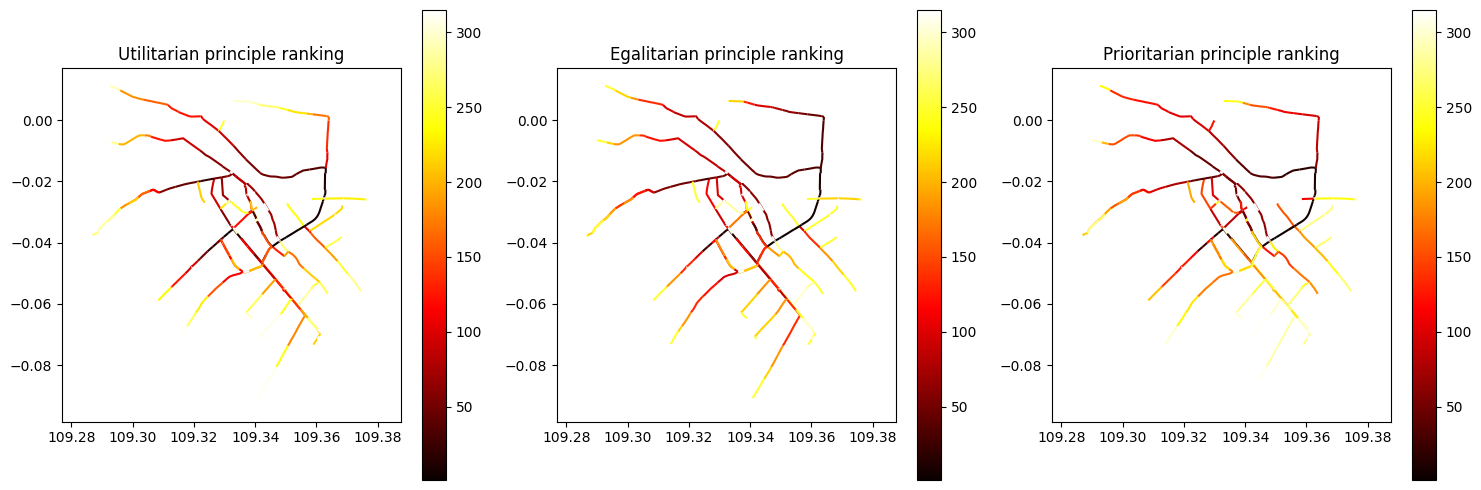

In [167]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
gdf.plot(column='traffic_ranked',cmap='hot',ax=axs[0],legend=True)
axs[0].set_title('Utilitarian principle ranking')
gdf.plot(column='traffic_egalitarian_ranked', cmap='hot', ax=axs[1], legend=True)
axs[1].set_title('Egalitarian principle ranking')
gdf.plot(column='traffic_prioritarian_ranked', cmap='hot',ax=axs[2], legend=True)
axs[2].set_title('Prioritarian principle ranking')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()



#### Egalitarian principle

<Axes: >

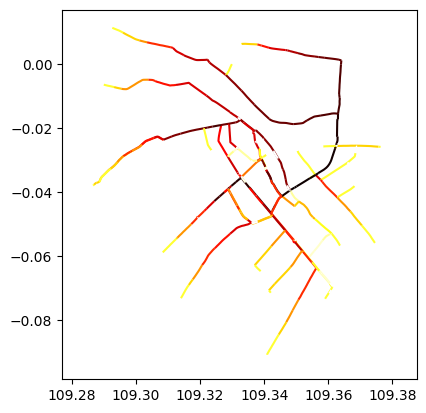

In [151]:
gdf.plot(column='traffic_egalitarian_ranked', cmap='hot')

#### Prioritarian principle

<Axes: >

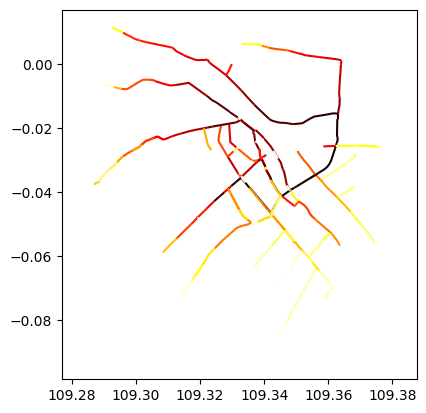

In [152]:
gdf.plot(column='traffic_prioritarian_ranked', cmap='hot')